In [2]:
#neurosynth term island annotations for fig 2d

In [ ]:
import scripts.neurosynth_tools as nt
import numpy as np
import nibabel as nb
import os
import matplotlib.pyplot as plt

In [3]:
n_perm=1000
spins= np.load(f'spin_dir/spins_{n_perm}.npy')
base_dir = '/data1/allen_surfaces/'
w_dir= '/data1/bigbrain/phate_testing/'

cortex=nb.load(os.path.join(base_dir,'hcp_surfs','fs_LR32k','Glasser_2016.32k.L.label.gii'))
cortex=cortex.darrays[0].data>0

In [4]:
import json
with open('weighted_island_vectors/glasser_rois.json') as f:
    d=json.load(f)
rois=[d['{}'.format(x)][0][2:-4] for x in np.arange(6)+1]

islands = np.loadtxt(os.path.join(w_dir,'weighted_island_vectors','clustered_islands.txt'))

In [5]:
from importlib import reload
reload(nt)

<module 'scripts.neurosynth_tools' from '/data1/bigbrain/phate_testing/scripts/neurosynth_tools.py'>

['response_inhibition_control' 'motor_cortex_hand'
 'cortex_anterior_cingulate' 'language_reading_word' 'food_taste_weight'
 'task_performance_cognitive' 'reward_feedback_striatum' 'eye_sleep_gaze'
 'stimulation_tms_bpd' 'motion_perception_visual' 'fear_threat_smokers'
 'visual_cortex_sensory' 'auditory_speech_temporal'
 'network_state_resting' 'imagery_mental_events' 'number_ips_numerical'
 'matter_volume_structural' 'control_conflict_task'
 'attention_attentional_target' 'social_empathy_moral' 'disease_ad_pd'
 'gyrus_frontal_inferior' 'prefrontal_cortex_pfc'
 'emotional_amygdala_negative' 'decision_making_risk' 'mpfc_social_medial'
 'memory_retrieval_encoding' 'action_actions_observation'
 'face_faces_facial' 'semantic_category_representations'
 'cerebellar_cerebellum_basal' 'pain_somatosensory_stimulation'
 'spatial_body_human' 'memory_working_wm'] [0.614 0.286 0.758 0.74  0.822 0.73  0.888 0.502 0.504 0.354 0.916 0.078
 0.728 0.628 0.382 0.968 0.668 0.46  0.348 0.78  0.964 0.888 0.

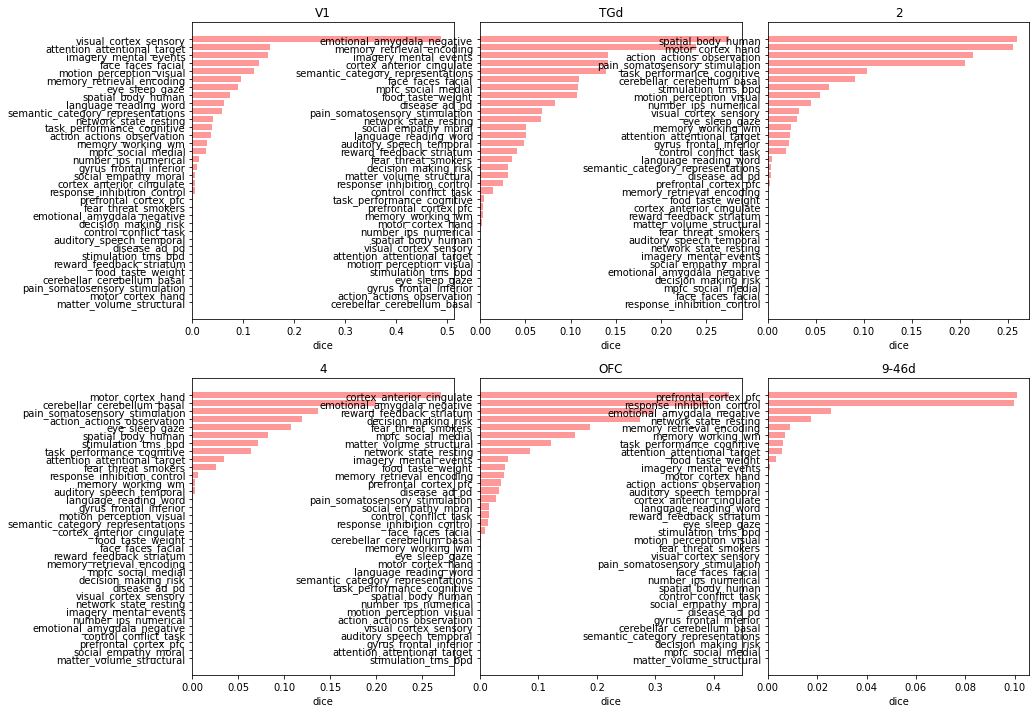

In [27]:
fig = plt.figure(figsize=(15,12))
gs = fig.add_gridspec(2,3, wspace=0.1,width_ratios=[1,1,1],height_ratios=[1,1])
axs = gs.subplots(sharex=False, sharey=False)
axes=axs.ravel()
terms = np.zeros((len(rois),34),dtype=object)
t_stats = np.zeros((len(rois),34))
pvals_all = np.zeros((len(rois),34))
top_term = []
for island,roi in enumerate(rois):
    
    map1=(islands==island)[cortex]
    t_stats[island], pvals, terms[island],perm_t=nt.neurosynth_binary_annotation(map1,
                                                                                 spins,test=nt.dice)
    nt.plot_neurosynth(t_stats[island],pvals,terms[island],title=f'{roi}',
                       test='dice',ax=axes[island])
    print(terms[island],pvals)
    top_term.append( terms[island][np.argsort(pvals)[0]])
    pvals_all[island] = pvals

In [18]:
top_term

['visual_cortex_sensory',
 'disease_ad_pd',
 'stimulation_tms_bpd',
 'motor_cortex_hand',
 'decision_making_risk',
 'response_inhibition_control']

In [28]:
n_per=2
bool_include = np.zeros_like(t_stats,dtype=bool)
for island,roi in enumerate(rois):
    bool_include[island,np.argsort(t_stats[island])[-n_per:]]=1

In [29]:
import pandas as pd

In [30]:
reduced_t=t_stats[:,np.any(bool_include,axis=0)]

reduced_p = pvals_all[:,np.any(bool_include,axis=0)]
reduced_terms = terms[:,np.any(bool_include,axis=0)][0]
unwanted_terms = ['cortex','cerebellar','anterior','cingulate',
                  'prefrontal','pfc','insula','insular','acc','anterior',
                 'dorsal','posterior','anterior','orbitofrontal','medial','dacc','dorsolateral','dlpfc',
                 'cerebellum','basal','ganglia','nucleus','thalamus','caudate', 'putamen',
                 'striatal', 'thalamic','nuclei', 'structures','cerebral', 'brainstem','lateral','ventral','amygdala',
                 'emotion','magnetic','resonance','pcc','rostral','frontal','ai','mpfc','action']
terms_sheet=pd.read_excel('neurosynth/NeuroSynthV5Topic50List.xlsx',skiprows=2)

for k,t in enumerate(reduced_terms):
    single_terms=reduced_terms[k].split('_')
    #find matching row
    scores=np.zeros(len(terms_sheet['Top terms']))
    for s_t in single_terms:
        for fl,full_list in enumerate(terms_sheet['Top terms']):
            if s_t in full_list.split(', ')[:n_per]:
                scores[fl]+=1
    term_index = np.argmax(scores)
    sc=0
    new_single_terms = single_terms.copy()
    for s_t in single_terms:
        if s_t in unwanted_terms:
            sc+=1
            new_single_terms.remove(s_t)
            while terms_sheet['Top terms'][term_index].split(', ')[2+sc] in unwanted_terms:
                sc+=1
            new_single_terms.append(terms_sheet['Top terms'][term_index].split(', ')[2+sc])
    print(new_single_terms)
    reduced_terms[k] = '\n'.join(new_single_terms)


['response', 'inhibition', 'control']
['motor', 'hand', 'movement']
['olfactory', 'odor', 'salience']
['visual', 'sensory', 'auditory']
['attention', 'attentional', 'target']
['control', 'cognitive', 'executive']
['emotional', 'negative', 'neutral']
['memory', 'retrieval', 'encoding']
['motor', 'control', 'network']
['spatial', 'body', 'human']


In [10]:
def reorder_modules_from_similarity(matrix):
    from scipy import cluster
    import seaborn as sns
    clustergrid = sns.clustermap(np.nan_to_num(np.corrcoef(matrix)));
    new_order = np.array(clustergrid.dendrogram_row.reordered_ind)
    plt.close('all')
    
    return new_order

In [11]:

new_order = reorder_modules_from_similarity(1-np.corrcoef(reduced_t.T))
#new_order = (len(new_order)-1-new_order)



In [12]:
new_order = np.roll(new_order,5)

In [31]:
#reorder terms
#new_order = np.array([1,11,8,10,9,2,6,0,4,3,5,7])
#rois=np.array(rois)[new_order]
reduced_t = np.array(reduced_t)[:,new_order]
reduced_p = np.array(reduced_p)[:,new_order]
reduced_terms=np.array(reduced_terms)[new_order]

In [36]:
np.save('weighted_island_vectors/neurosynth_top.npy',reduced_terms[np.argmax(reduced_t,axis=1)])


In [302]:
cmap = plt.get_cmap("tab20")
colors = cmap(np.arange(20))

In [303]:
#colors=plt.rcParams['axes.prop_cycle'].by_key()['color']
colors=colors[np.round(np.linspace(0,19,7)).astype(int)]

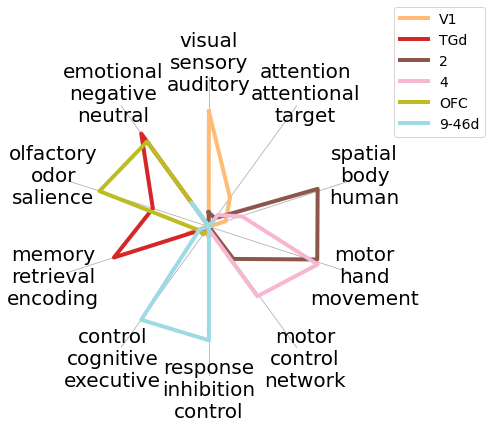

In [304]:
plt.figure(figsize=(6,6))
plt.rcParams.update({'font.size': 14})

ax = plt.axes(polar=True)
ax.spines['polar'].set_visible(False)
for k,t in enumerate(rois):
    #vals=np.clip(0,np.max(reduced_t[k]),reduced_t[k])
    vals = reduced_t[k]
    vals = np.hstack([vals,vals[0]])
    vals=vals/np.max(vals)
    offset=0
    if t in ['2','4']:
        offset = [0.02,-0.02][['2','4'].index(t)]
    
    ax.plot(np.linspace(np.pi*2,0,len(reduced_terms)+1)+offset,vals,
           linewidth=4,label=t,c=colors[k+1])
ax.set_ylim([0,1.3])
ax.set_xticks(np.linspace(np.pi*2,0,len(reduced_terms)+1)[:-1])
ax.set_xticklabels(reduced_terms,zorder=0,size=20,ha='center')
#ax.xaxis.labelpad = 50
#ax.set_rlabel_position(-22.5)
# pos=ax.get_theta_label_position()
# ax.set_th
ax.set_yticks([])
ax.set_theta_zero_location("N")

#ax.xaxis.grid(False)
#ax.xaxis.set_visible(False)        
plt.tight_layout()
#ax.set_yticklabels(['','','','','',''])
plt.legend(loc=[1.12,0.8])
plt.savefig('neurosynth/neurosynth_island_annotations.pdf')